In [213]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [214]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0] 
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)  


	
numpy.random.seed(7)

In [215]:
#using only "open"  coloumn

dataframe = read_csv('/content/trainset.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
# dataset = dataset[:1200]
len(dataset)

1259

In [216]:
dataframe.isna().sum()

Open    0
dtype: int64

In [217]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [218]:
# dataset = (dataset[:1200])

In [219]:
len(dataset)

1259

In [220]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
print(train_size, test_size)

881 378


In [221]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [222]:
look_back = 5

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)

(875, 5)
(372, 5)


In [223]:
# IMP   //shape how lstm model expects

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0],trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape)
print(testX.shape)

(875, 5, 1)
(372, 5, 1)


In [224]:
model = Sequential()
model.add(LSTM(50 ,input_shape=(look_back, 1),return_sequences=True ))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 5, 50)             10400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [225]:
es = EarlyStopping(monitor='val_loss', patience = 5)
callbacks = [es]
history = model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=1, 
                    validation_data=(testX, testY))

Epoch 1/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 2/30
875/875 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 5.5214e-04
Epoch 3/30
875/875 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 4/30
875/875 [==============================] - 4s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/30
875/875 [==============================] - 4s 4ms/step - loss: 9.4926e-04 - val_loss: 4.8821e-04
Epoch 6/30
875/875 [==============================] - 3s 4ms/step - loss: 8.0815e-04 - val_loss: 0.0014
Epoch 7/30
875/875 [==============================] - 4s 4ms/step - loss: 7.8363e-04 - val_loss: 0.0040
Epoch 8/30
875/875 [==============================] - 3s 4ms/step - loss: 8.4158e-04 - val_loss: 9.8669e-04
Epoch 9/30
875/875 [==============================] - 3s 4ms/step - loss: 6.6292e-04 - val_loss: 0.0030
Epoch 10/30
875/875 [==============================] - 4s 4ms/step -

In [226]:
(history.history['val_loss'][-1])

0.00020227768982294947

In [227]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

dataset = scaler.inverse_transform(dataset)

In [228]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 10.90 RMSE
Test Score: 10.31 RMSE


In [229]:
# testY = numpy.reshape(testY, (testY[1], testY[0]))
testY = testY.transpose()

testPredict.shape, testY.shape

((372, 1), (372, 1))

In [230]:
testPredict[:10], testY[:10]

(array([[704.5418 ],
        [711.2519 ],
        [721.00073],
        [727.0302 ],
        [727.46173],
        [730.5515 ],
        [729.2363 ],
        [733.9406 ],
        [740.4545 ],
        [744.47064]], dtype=float32), array([[708.04997692],
        [719.11995994],
        [723.61998712],
        [721.57998978],
        [725.73000429],
        [722.70998873],
        [729.89004632],
        [737.3300417 ],
        [740.35999834],
        [741.85997858]]))

In [231]:
# train_new = dataset[:875]


train_new = (dataset[:(train_size-(look_back-1))])
predictTotal2 = numpy.concatenate((train_new, testPredict))


dataset.shape, train_new.shape, predictTotal2.shape

((1259, 1), (877, 1), (1249, 1))

In [232]:
testPredict[:10]

array([[704.5418 ],
       [711.2519 ],
       [721.00073],
       [727.0302 ],
       [727.46173],
       [730.5515 ],
       [729.2363 ],
       [733.9406 ],
       [740.4545 ],
       [744.47064]], dtype=float32)

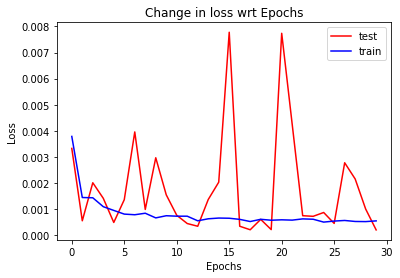

In [233]:
plt.plot(history.history['val_loss'], color='red', label='test')
plt.plot(history.history['loss'], color='blue', label='train')
plt.title('Change in loss wrt Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[]

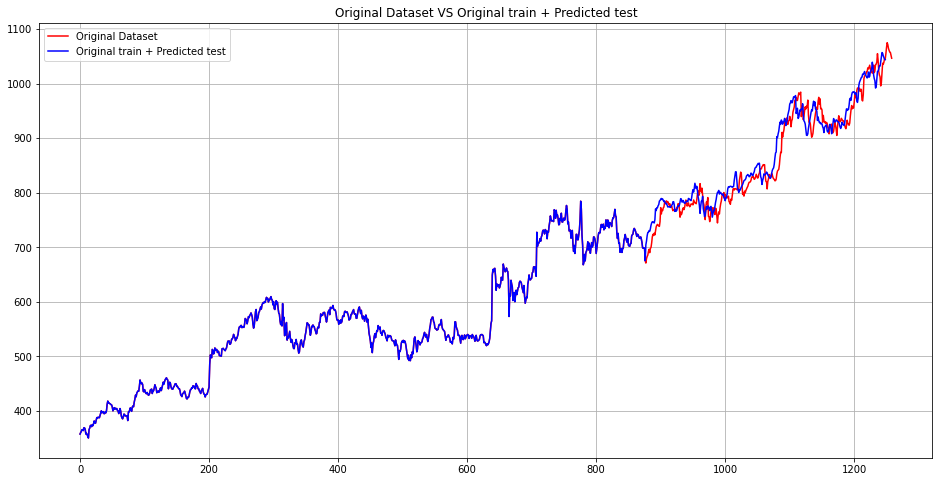

In [239]:
plt.figure(figsize=(16,8))
plt.plot(dataset, color='red', label='Original Dataset')
plt.plot(predictTotal2, color='blue',label="Original train + Predicted test" )
plt.title('Original Dataset VS Original train + Predicted test')
plt.legend()
plt.grid(True)
plt.plot()

[]

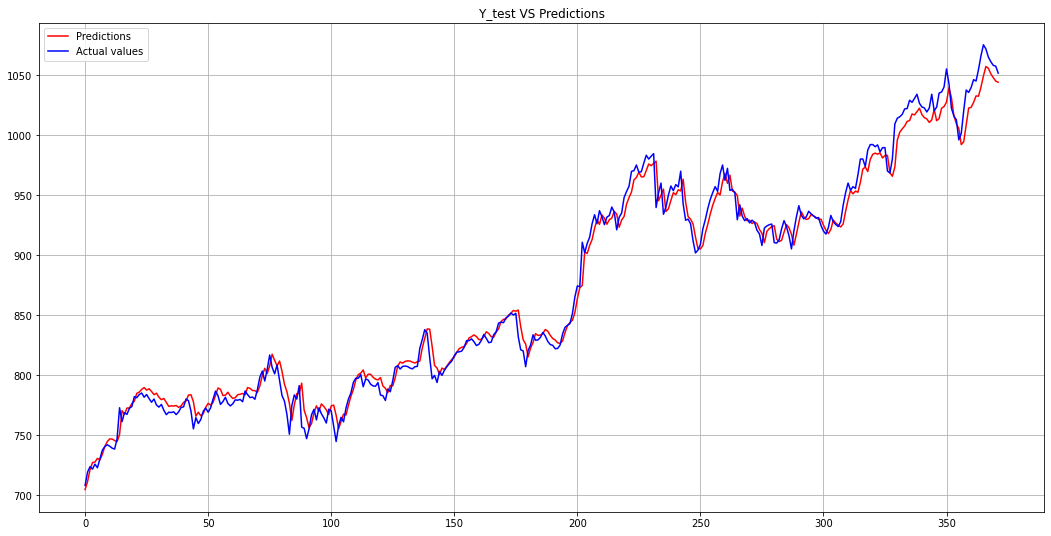

In [240]:
# A close view of actual and predicted values

plt.figure(figsize=(18,9))
plt.plot(testPredict, color='red', label='Predictions')
plt.plot(testY, color='blue', label='Actual values')
plt.title('Y_test VS Predictions')
plt.legend()
plt.grid(True)
plt.plot()